In [1]:
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt



Current data is shaped: (1250, 100, 514)


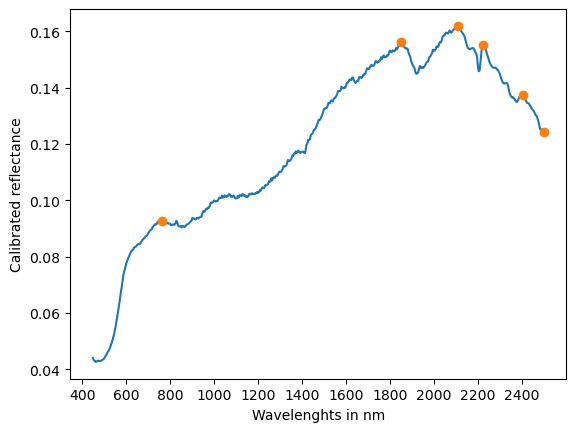

In [2]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 490
curr_y = 54

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')
plt.xticks(np.arange(400,2500, step = 200))

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel,
                   width = 5)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

In [4]:
# Master peak ranges
# This data will need to be committed to a database table so that it can be extracted
# in a more easily edited central location
min_list = np.sort(np.asarray([820, 2490, 645, 790, 880, 1370, 1450, 1465, 1535, 1710, 1890, 1935, 2145, 2185, 2230, 2220, 2270, 2325, 2345, 2375]))
max_list = np.sort(np.asarray([980, 2550, 675, 810, 1150, 1420, 1490, 1500, 1565, 1785, 1940, 1960, 2185, 2230, 2265, 2300, 2330, 2370, 2390, 2415]))
mineral_label = ['iron oxides (goethite, hematite)', 'carbonates', 'molybdenite', 
                 'REE', 'pyroxene', 'micas, clays', 'jarosite', 'alunite', 
                 'epidote', 'sulphates', 'all OH, zeo', 'gypsum',
                 'pyrophyllite', 'Al-OH', 'chlorite, biotite', 'Al-fe smectites', 
                 'Fe-Mg smectites', 'chlorite, biotite', 'tourmaline', 'amphiboles, biotite']
hull_correct_bool = [False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]

0

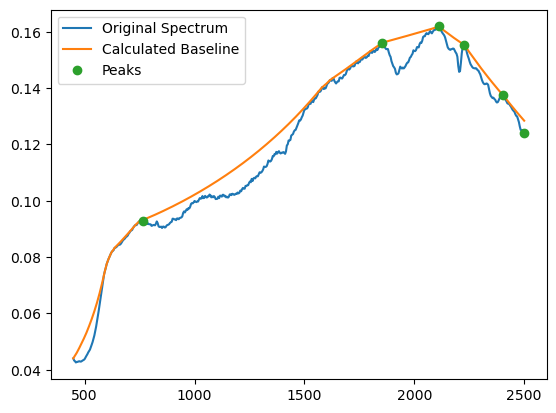

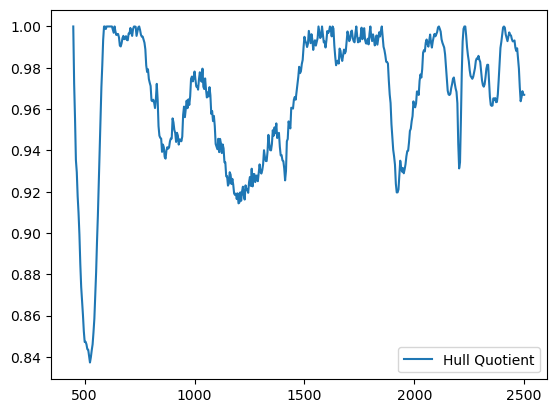

In [12]:
baseline_fitter = Baseline(wav_array,
                           check_finite=False)

# Invert the data 
pix_inverse = 1 / curr_pixel 

# Calculate the baseline
baseline_inv = baseline_fitter.snip(pix_inverse,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0)[0]

# Invert the result
curr_baseline = 1 / baseline_inv         

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

plt.figure()
plt.plot(wav_array, curr_pixel/curr_baseline, label='Hull Quotient')
plt.legend()

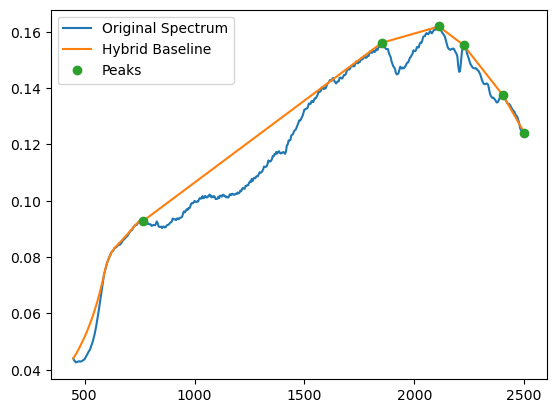

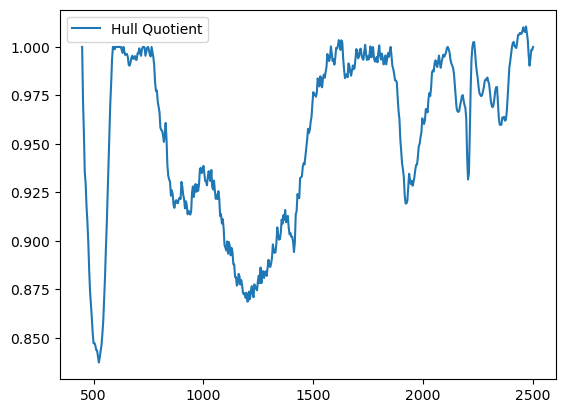

In [58]:
# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull


prelim_hull = interpolate_linear(curr_pixel[peaks[0]:],
                                 peaks - peaks[0])

concat_hull = np.concatenate((curr_baseline[0:peaks[0]],
                              prelim_hull))

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, concat_hull, label='Hybrid Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

curr_quotient = curr_pixel/concat_hull

plt.figure()
plt.plot(wav_array,
         curr_quotient,
         label='Hull Quotient')
plt.legend()

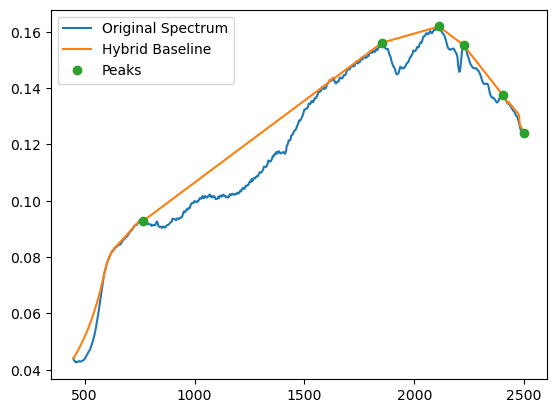

In [59]:
# Identify if the quotient contains any areas greater than 1 (it shouldn't)
n_gt_one = (curr_quotient > 1).sum()
if n_gt_one > 0:
# Replace hybrid locations with the original baseline if it crossed zero
    concat_hull[curr_quotient > 1] = curr_baseline[curr_quotient > 1]
    
    plt.plot(wav_array, curr_pixel, label='Original Spectrum')
    plt.plot(wav_array, concat_hull, label='Hybrid Baseline')
    plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
    plt.legend()

648.0
672.0
792.0
808.0


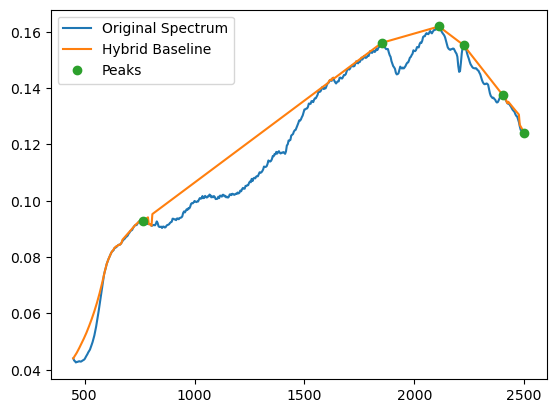

In [62]:
intermediate_hull = concat_hull

for i, hull_alter in enumerate(hull_correct_bool):
# i = 0
    hull_alter
    curr_min = min_list[i]
    curr_max = max_list[i]
    # If we aren't supposed to alter the hull revert it to the original values in that range 
    if not hull_alter:
    # Get the indices for the current values 
        min_ind = np.where(wav_array >= curr_min)[0].min()
        max_ind = np.where(wav_array <= curr_max)[0].max()
        print(wav_array[min_ind])
        print(wav_array[max_ind])
        intermediate_hull[min_ind:max_ind] = curr_pixel[min_ind:max_ind]

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
# plt.plot(wav_array, concat_hull, label='Concat Baseline')
plt.plot(wav_array, intermediate_hull, label='Hybrid Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

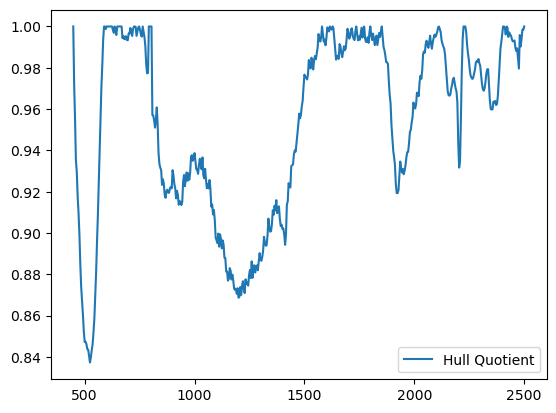

In [65]:
curr_quotient = curr_pixel/intermediate_hull

plt.figure()
plt.plot(wav_array,
         curr_quotient,
         label='Hull Quotient')
plt.legend()